# Проект по созданию суммаризатора для конспектов (SmartNotes)


## Установка необходимых библиотек
- pymorphy2/natasha — для работы с данными в виде текста на русском языке.
- tqdm — для визуализации прогресса.
- rouge-score/bert-score — для оценки качества текста (например, в суммаризации или машинном переводе).
- nltk — общие NLP-инструменты (токенизация, стемминг, метрики).

In [ ]:
pip install datasets pymorphy2 tqdm natasha rouge-score bert-score nltk accelerate -U datasets transformers evaluate dask

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.1/362.1 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 132.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 114.8 MB/s eta 0:00:00
   ━━━

## Импорты для анализа

In [ ]:
import pandas as pd
import dask.dataframe as dd
from datasets import load_dataset

from nltk.corpus import stopwords
import nltk
from natasha import MorphVocab
from wordcloud import WordCloud

from tqdm import tqdm
from collections import Counter

import matplotlib.pyplot as plt

## Импорты для модели

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    MT5ForConditionalGeneration,
    MT5Tokenizer
)

from datasets import load_dataset
import evaluate
from nltk.tokenize import sent_tokenize
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

from bert_score import score as bert_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

from tqdm import tqdm
import re


device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1 Анализ датасета

## 1.1 Скачивание

Датасет **Gazeta** — это русскоязычный набор данных для задач автоматического суммаризации текстов, созданный **Ильёй Гусевым** и доступный на платформе **Hugging Face**.  

### **Основная информация**  
- **Название:** `IlyaGusev/gazeta`  
- **Тип данных:** Новостные статьи и их аннотации (суммаризации).  
- **Язык:** Русский.  
- **Размер:** Около **50 000** пар "статья-аннотация".  
- **Источник:** Новостной портал **[Gazeta.Ru](https://www.gazeta.ru/)**.  

### **Структура датасета**  
Каждый пример содержит:  
- `title` – заголовок статьи.  
- `text` – полный текст статьи.  
- `summary` – краткое содержание (аннотация), написанное редакторами Gazeta.Ru.  
- `date` – дата публикации.  

Пример записи:  
```json
{
  "title": "В России изменились правила сдачи экзаменов на права",
  "text": "С 1 апреля в России вступили в силу новые правила...",
  "summary": "Новые правила сдачи экзаменов на водительские права...",
  "date": "2021-04-01"
}
```

### **Сферы применения**  
Датасет используется для:  
- **Автоматического суммаризирования** (abstractive и extractive summarization).  
- **Обучения NLP-моделей** (например, `ruT5`, `mBART`, `FRED-T5`).  
- **Оценки качества генеративных моделей** (метрики ROUGE, BLEU).  

In [ ]:
# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("IlyaGusev/gazeta")

In [ ]:
data = ds["train"].to_pandas()

# Первые 3 примера
data[["text", "summary"]].head(3)

,text,summary
0,Сегодня транспортный налог начисляется в завис...,С 2011 года правительство отменяет самый раздр...
1,Словосочетание «музыкальный кинофестиваль» уже...,"Британские затворники, московские модники, бра..."
2,После более чем 12-часовых консультаций Совет ...,Совбез ООН собрался на экстренное совещание дл...


Если не работает datasets:

In [ ]:
# Загрузка данных в Dask DataFrame
splits = {
    'train': '**/train/*.parquet',
    'validation': 'default/validation/0000.parquet',
    'test': 'default/test/0000.parquet'
}
dask_df = dd.read_parquet("hf://datasets/IlyaGusev/gazeta/" + splits["train"])

# Конвертация в Pandas DataFrame
data = dask_df.compute()  # Выполняет вычисления и возвращает pd.DataFrame

data[["text", "summary"]].head(3)

,text,summary
0,Сегодня транспортный налог начисляется в завис...,С 2011 года правительство отменяет самый раздр...
1,Словосочетание «музыкальный кинофестиваль» уже...,"Британские затворники, московские модники, бра..."
2,После более чем 12-часовых консультаций Совет ...,Совбез ООН собрался на экстренное совещание дл...


## 1.2 Количество и уникальность


In [ ]:
data.describe()[:2]

,text,summary,title,date,url
count,60964,60964,60964,60964,60964
unique,60844,60817,60762,60807,60964


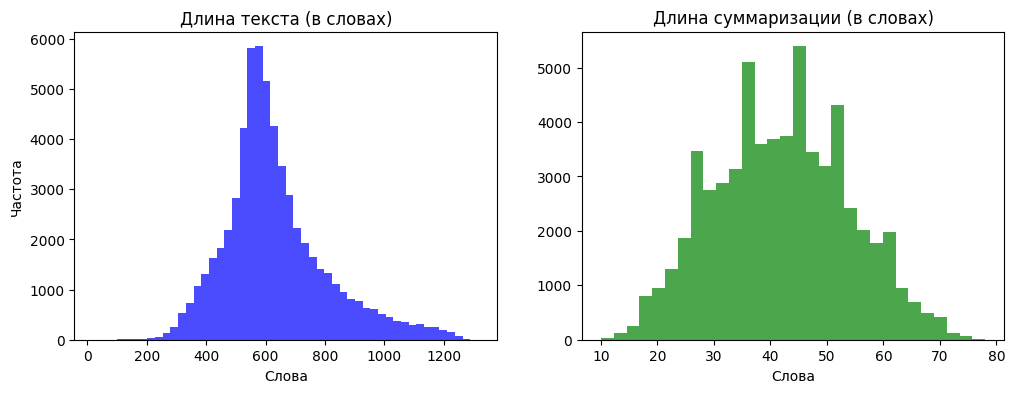

Средняя длина текста: 4525 символов
Средняя длина суммаризации: 311 символов


In [ ]:
# Длина в словах (разделение по пробелам)
data["text_words"] = data["text"].apply(lambda x: len(x.split()))
data["summary_words"] = data["summary"].apply(lambda x: len(x.split()))

# Гистограммы
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(data["text_words"], bins=50, color="blue", alpha=0.7)
plt.title("Длина текста (в словах)")
plt.xlabel("Слова")
plt.ylabel("Частота")

plt.subplot(1, 2, 2)
plt.hist(data["summary_words"], bins=30, color="green", alpha=0.7)
plt.title("Длина суммаризации (в словах)")
plt.xlabel("Слова")
plt.show()


print(f"Средняя длина текста: {data['text'].apply(len).mean():.0f} символов")
print(f"Средняя длина суммаризации: {data['summary'].apply(len).mean():.0f} символов")

## 1.3 Популярность

In [ ]:
nltk.download("stopwords")
stopwords_ru = set(stopwords.words("russian"))
morph_vocab = MorphVocab()

def lemmatize_word(word):
    # Правильный способ лемматизации через Natasha
    word_parsed = morph_vocab(word.lower())[0]
    #print(word_parsed)
    return word_parsed.normal if word_parsed.normal else word.lower()

def get_top_words(texts, n=20):
    words = []
    for text in tqdm(texts):
        words.extend([
            lemmatize_word(word)
            for word in text.split()
            if word.isalpha() and word.lower() not in stopwords_ru
        ])
    return Counter(words).most_common(n)

# Пример использования
top_text_words = get_top_words(data["text"][:10000]) # TODO: перезапустить на полном
top_summary_words = get_top_words(data["summary"])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 60964/60964 [01:04<00:00, 941.01it/s] 


In [ ]:
count_words = pd.concat([
    pd.DataFrame(top_text_words, columns=['Топ слов в полном тексте','Среднее кол-во на текст (1)']),
    pd.DataFrame(top_summary_words, columns=['Топ слов в суммаризации', 'Среднее кол-во на текст (2)'])], axis=1)
count_words['Среднее кол-во на текст (1)'] /= 10000
count_words['Среднее кол-во на текст (2)'] /= 60964
count_words

,Топ слов в полном тексте,Среднее кол-во на текст (1),Топ слов в суммаризации,Среднее кол-во на текст (2)
0,который,3.3267,который,0.258087
1,год,2.2014,россия,0.189686
2,это,2.0113,российский,0.170953
3,свой,1.7983,год,0.151073
4,первый,1.4590,свой,0.151040
5,стать,1.2186,президент,0.118824
6,также,1.1740,стать,0.114510
7,матч,1.0555,новый,0.114330
8,один,0.9920,первый,0.092825
9,российский,0.9675,это,0.092628


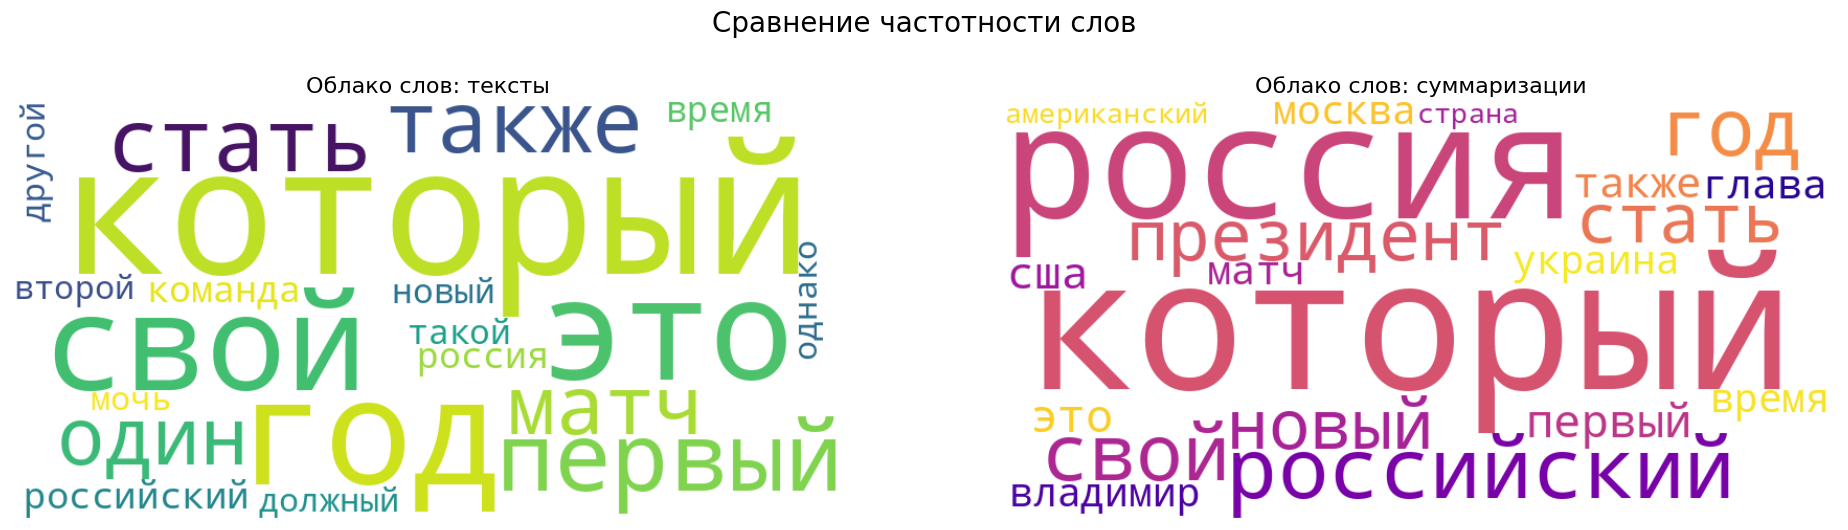

In [ ]:
# Создаем фигуру с двумя субплогами
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# Генерируем первое облако слов (для текстов)
wordcloud1 = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'  # Можно изменить цветовую схему
).generate_from_frequencies(dict(top_text_words))

# Отображаем первое облако
ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.set_title("Облако слов: тексты", fontsize=16)
ax1.axis("off")

'''
ВТОРОЕ ОБЛАКО
'''
# Генерируем второе облако слов (для суммаризаций)
wordcloud2 = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='plasma'  # Другая цветовая схема для контраста
).generate_from_frequencies(dict(top_summary_words))

# Отображаем второе облако
ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.set_title("Облако слов: суммаризации", fontsize=16)
ax2.axis("off")

# Добавляем общий заголовок
plt.suptitle("Сравнение частотности слов", fontsize=20, y=1.05)

# Настраиваем отступы между графиками
plt.tight_layout()

# Показываем результат
plt.show()

# 2 Модель

In [ ]:
dataset = load_dataset("IlyaGusev/gazeta", split={
    'train': 'train[:40%]',
    'test': 'test[:10%]'
})

## 2.1 Выбор модели

### Объяснение модели MT5 (Multilingual T5)

---
**MT5** (Multilingual Text-to-Text Transfer Transformer) — это многоязычная версия модели **T5** от Google, предназначенная для задач обработки естественного языка (NLP) в формате **"текст-в-текст"**.  
- **Особенности**:  
  - Поддерживает более 100 языков, включая русский.  
  - Основана на архитектуре Transformer (как и оригинальный T5).
---
MT5 применяется для **многоязычных NLP-задач**, включая:  
- **Суммаризацию текста** (как в примере: преобразование исходного текста в краткий пересказ).  
- **Машинный перевод** (например, с английского на русский).  
- **Ответы на вопросы** (Question Answering).  
- **Классификацию текста**.
---

#### **Как устроена модель?**  
MT5 основана на **архитектуре Transformer** (как и T5), но с адаптацией для многоязычия.  

##### **Ключевые компоненты**:  
1. **Токенизатор**:  
   - Преобразует текст в числовые токены (слова/подслова) с учетом многоязычия.  
   - Использует **SentencePiece** (как в оригинальном T5).  

2. **Архитектура модели**:  
   - **Encoder-Decoder структура**:  
     - **Encoder** (кодировщик): Анализирует входной текст.  
     - **Decoder** (декодировщик): Генерирует выходной текст (например, суммаризацию).  
   - **Количество слоев** (для `mt5-small`):  
     - 8 трансформер-слоев в encoder и 8 в decoder.  
     - 6 голов внимания (attention heads) в каждом слое.  
     - Размер эмбеддингов (вектора слова): 512.  
   - **Cross-Attention** (в decoder): Связывает encoder и decoder для генерации осмысленного выхода.  

4. **Позиционные эмбеддинги**:  
   - Учитывают порядок слов в тексте.  

##### **`mt5-small`**:  
| Параметр            | Значение       |  
|---------------------|---------------|  
| Количество слоев    | 8 (encoder) + 8 (decoder) |  
| Голов внимания      | 6             |  
| Размер эмбеддинга   | 512           |  
| Параметры модели    | ~300 млн      |  

In [ ]:
# Блок 3: Инициализация токенизатора и предварительная обработка
model_name = "google/mt5-small"  # Или "google/mt5-base" для большей модели
tokenizer = MT5Tokenizer.from_pretrained(model_name)
model = MT5ForConditionalGeneration.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.
You are using the default legacy behaviour of the <class 'transformers.models.mt5.tokenization_mt5.MT5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

## 2.2 Обучение модели

In [ ]:
# --- ЗАМОРОЗКА ЭНКОДЕРА ---
for param in model.encoder.parameters():
    param.requires_grad = False  # Отключаем градиенты для всех параметров энкодера

print("Энкодер заморожен:", all(not p.requires_grad for p in model.encoder.parameters()))

Энкодер заморожен: True


In [ ]:
def preprocess_function(examples):
    inputs = [f"simplify \| {text}" for text in examples["text"]]  # Добавляем префикс для T5
    targets = examples["summary"]

    model_inputs = tokenizer(
        inputs,
        max_length=512,
        truncation=True,
        padding="max_length"
    )

    labels = tokenizer(
        text_target=targets,
        max_length=128,
        truncation=True,
        padding="max_length"
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/24386 [00:00<?, ? examples/s]

Map:   0%|          | 0/679 [00:00<?, ? examples/s]

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=False,  # Отключить, если нет GPU
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
)

<ipython-input-10-9d65cf72505e>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: egorhorobryh (egorhorobryh-samara-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,2.107900,1.781685
2,2.022800,1.749298
3,1.981900,1.738459
4,1.955400,1.727111


Epoch,Training Loss,Validation Loss
1,2.107900,1.781685
2,2.022800,1.749298
3,1.981900,1.738459
4,1.955400,1.727111
5,1.911700,1.723978


TrainOutput(global_step=30485, training_loss=2.028768306742814, metrics={'train_runtime': 17253.7174, 'train_samples_per_second': 7.067, 'train_steps_per_second': 1.767, 'total_flos': 6.44704498089984e+16, 'train_loss': 2.028768306742814, 'epoch': 5.0})

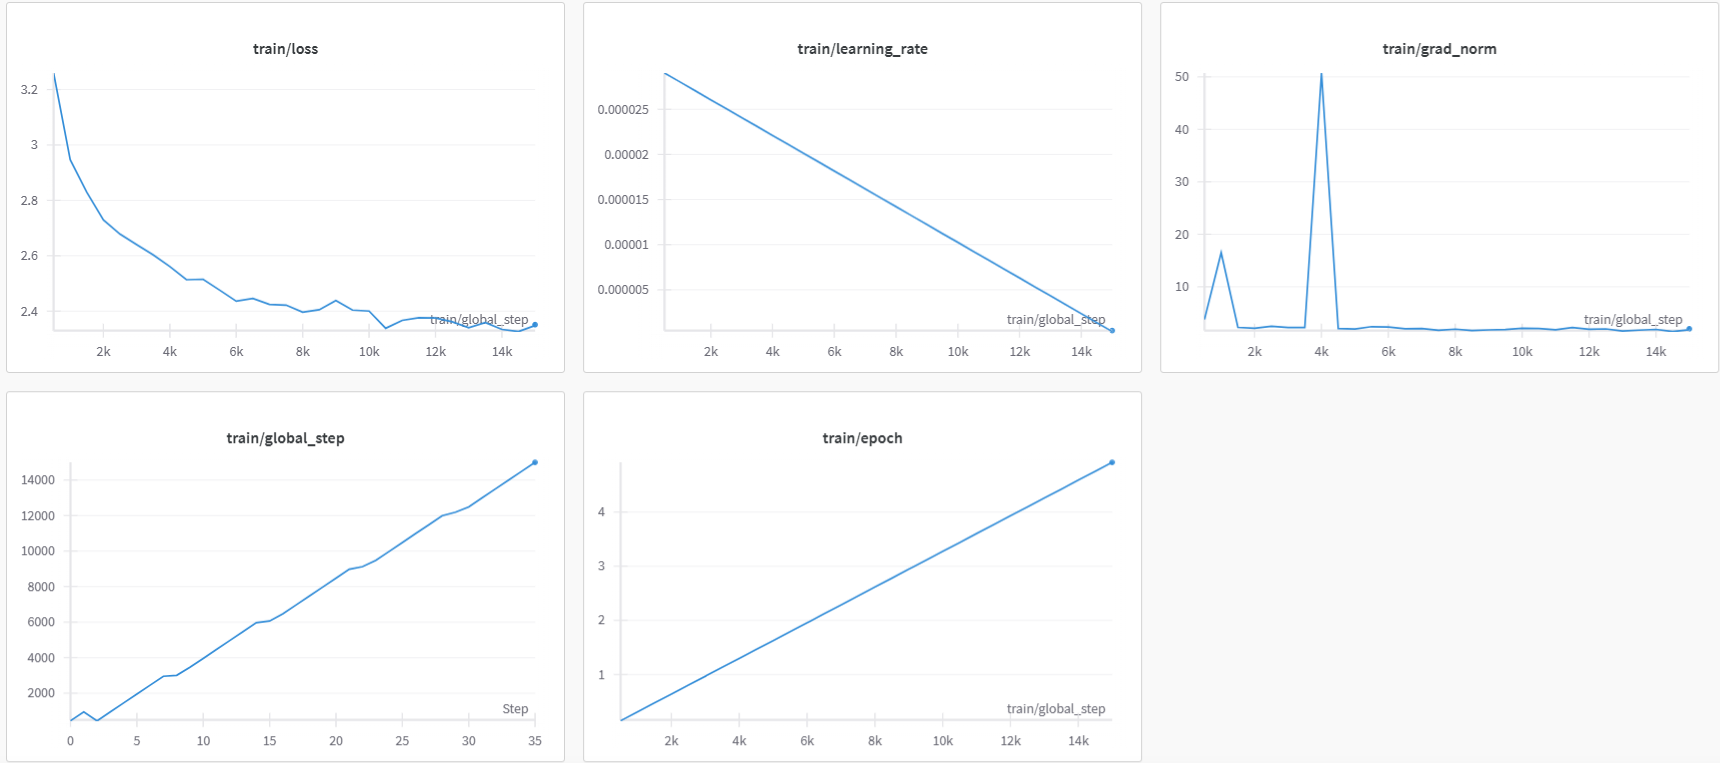

## 2.3 Инференс модели

In [ ]:
'''
ДЛЯ ДООБУЧЕНИЯ И ИНФЕРЕНСа
'''
from google.colab import drive
drive.mount('/content/drive')

drive = '/content/drive/MyDrive'
root = drive + '/ML-CK-model'

tokenizer = MT5Tokenizer.from_pretrained(root)
model = MT5ForConditionalGeneration.from_pretrained(root).to(device)

Mounted at /content/drive


In [ ]:
# Блок 8: Функция для генерации суммаризации
def generate_summary(text, max_length=1024, min_length=56):
    # Очистка текста
    def clean_text(text):
        text = re.sub(r'[^\w\s.,!?;:]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    cleaned_text = clean_text(text)

    # Токенизация
    inputs = tokenizer(
        cleaned_text,
        return_tensors="pt",
        truncation=True,
        max_length=1024
    ).to(device)

    # Генерация суммаризации
    try:
        with torch.no_grad():
            summary_ids = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=max_length,
                min_length=min_length,
                num_beams=4,
                length_penalty=1.0,
                no_repeat_ngram_size=3,
                early_stopping=True
            )
        summary_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        return summary_text
    except Exception as e:
        print(f"Ошибка при генерации: {e}")
        return None

# Пример использования
sample_text = """
В прошлых разделах мы научились соединять базовые алгоритмы в ансамбль с помощью бэггинга (и, в частности, строить из решающих деревьев случайные леса). Теперь мы рассмотрим другой способ объединять базовые алгоритмы в композицию — градиентный бустинг. В ходе обучения случайного леса каждый базовый алгоритм строится независимо от остальных. Бустинг, в свою очередь, воплощает идею последовательного построения линейной комбинации алгоритмов. Каждый следующий алгоритм старается уменьшить ошибку текущего ансамбля.
Бустинг, использующий деревья решений в качестве базовых алгоритмов, называется градиентным бустингом над решающими деревьями, (Gradient Boosting on Decision Trees, GBDT).
Он отлично работает на выборках с «табличными», неоднородными данными. Пример таких данных — описание пользователя Яндекса через его возраст, пол, среднее число поисковых запросов в день, число заказов такси и так далее. Такой бустинг способен эффективно находить нелинейные зависимости в данных различной природы.
Этим свойством обладают все алгоритмы, которые используют деревья решений, однако именно GBDT обычно выигрывает в подавляющем большинстве задач.
"""

summary = generate_summary(sample_text)
print("Оригинальный текст:")
print(sample_text[:160] + '\n' + sample_text[160:320] + "...(длина текста: " + str(len(sample_text.split())) + " слов)")
print("\nСгенерированное суммаризация:")
print(summary)

Оригинальный текст:

В прошлых разделах мы научились соединять базовые алгоритмы в ансамбль с помощью бэггинга (и, в частности, строить из решающих деревьев случайные леса). Теперь
 мы рассмотрим другой способ объединять базовые алгоритмы в композицию — градиентный бустинг. В ходе обучения случайного леса каждый базовый алгоритм строится н...(длина текста: 147 слов)

Сгенерированное суммаризация:
В ходе обучения случайного леса можно построить линейную комбинацию алгоритмов, а также построить базовые алгоритмы в ансамбль. Такой бустинг может выиграть линейные комбинации.


 ## 2.4 Сохранение модели

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive = '/content/drive/MyDrive'

In [ ]:
save_path = drive + '/ML-CK-model-1'
# Сохраняем локально
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/ML-CK-model-1/tokenizer_config.json',
 '/content/drive/MyDrive/ML-CK-model-1/special_tokens_map.json',
 '/content/drive/MyDrive/ML-CK-model-1/spiece.model',
 '/content/drive/MyDrive/ML-CK-model-1/added_tokens.json')

## 2.5 Оценка модели

In [ ]:
test_data = ds['test']
texts = [item['text'] for item in test_data][:1000]  # оригинальные тексты
references = [item['summary'] for item in test_data][:1000]  # идеальные суммаризации

In [ ]:
generated_summaries = [generate_summary(text) for text in tqdm(texts)]

# Вычисление BERTScore
P_bert, R_bert, F1_bert = bert_score(generated_summaries, references, lang='ru')

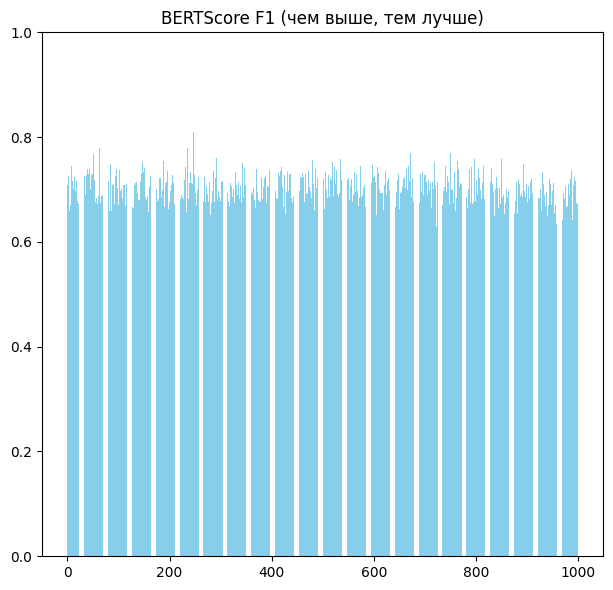


Подробные результаты (первые 5 строк):


,Text,Reference,Generated,BERTScore_F1,P_bert,R_bert
0,На этих выходных в Берлине прошли крупные акци...,Протестующие против антикоронавирусных мер нем...,В Берлине прошли массовые акции протеста проти...,0.707693,0.735889,0.681579
1,Высокопоставленная американская и израильская ...,"Делегации Израиля и США прилетели в ОАЭ, где о...",Накануне визита президент США Дональд Трамп об...,0.697340,0.719693,0.676333
2,Одна из руководителей Координационного совета ...,Белорусская оппозиция в лице экс-кандидата в п...,Президент Белоруссии Виктор Бабарико объявил о...,0.725091,0.753082,0.699107
3,Россия считает действия ВС США во время учений...,Действия американских ВС в Эстонии во время уч...,В Эстонии пройдут совместные стрельбы ВС США в...,0.759449,0.801959,0.721218
4,С 1 сентября в России вступают в силу поправки...,Поправки в российский закон «О банкротстве» вс...,В России начнется волна заявлений о несостояте...,0.659186,0.658607,0.659765



Средний BERTScore F1: 0.702

Средний P_bert F1: 0.723

Средний R_bert F1: 0.682


In [ ]:

# Создание таблицы с результатами
results = pd.DataFrame({
    'Text': texts,
    'Reference': references,
    'Generated': generated_summaries,
    'BERTScore_F1': F1_bert.numpy(),
    'P_bert': P_bert.numpy(),
    'R_bert': R_bert.numpy()
})
# Визуализация
plt.figure(figsize=(12, 6))

# График BERTScore
plt.subplot(1, 2, 1)
plt.bar(range(len(results.BERTScore_F1)), results.BERTScore_F1, color='skyblue')
plt.title('BERTScore F1 (чем выше, тем лучше)')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Вывод таблицы с результатами (первые 5 строк)
print("\nПодробные результаты (первые 5 строк):")
display(results.head())

# Средние значения
print(f"\nСредний BERTScore F1: {F1_bert.mean():.3f}")
print(f"\nСредний P_bert F1: {P_bert.mean():.3f}")
print(f"\nСредний R_bert F1: {R_bert.mean():.3f}")

# 3 Выводы

В результате работы над проектом - я обучил нейронную сеть, предназначенную для суммаризации (сокращения) текстов. Во время работы над проектом я получил полезные
прикладные навыки, познакомился поближе с различными библиотеками, фреймворками, которые мне пригодятся в будущем.